In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [27]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [28]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [29]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [30]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [31]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    # ##################################################### repeatable!
    # next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                reuse=True)
    # next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                             reuse=True)
    # gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                      action_size=action_size, reuse=True)
    # dones2 = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    # gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones2)
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                 labels=tf.zeros_like(gQs3))) # 0-1
    # aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                  labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [32]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [33]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [34]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [35]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [36]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [37]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [38]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [39]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [41]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                #if np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0:
                if len(dones) > 1:
                    # print('np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0: ', 
                    #       np.count_nonzero(dones), len(dones), np.max(rates))
                    break
            #             if np.count_nonzero(dones)!=1 and len(dones) < 1 and np.max(rates) <= 0:
            #                 print(np.count_nonzero(dones), len(dones), np.max(rates))
            #                 break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.next_states: next_states,
                                            #model.rewards: rewards,
                                            model.dones: dones,
                                            model.rates: rates})
            dloss, _ = sess.run([model.d_loss, model.d_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print('dones:', 
            #       len(dones), np.count_nonzero(dones), 
            #       len(dones1), np.count_nonzero(dones1), 
            #       len(dones2), np.count_nonzero(dones2))
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:24.0000 R:24.0000 rate:0.0480 aloss:1.3965 dloss:1.6120 aloss2:1.8101 exploreP:0.9976
Episode:1 meanR:19.0000 R:14.0000 rate:0.0280 aloss:1.4309 dloss:1.5057 aloss2:2.1519 exploreP:0.9962
Episode:2 meanR:32.3333 R:59.0000 rate:0.1180 aloss:1.3893 dloss:1.6299 aloss2:1.7540 exploreP:0.9904
Episode:3 meanR:33.2500 R:36.0000 rate:0.0720 aloss:1.3846 dloss:1.6285 aloss2:1.7230 exploreP:0.9869
Episode:4 meanR:30.0000 R:17.0000 rate:0.0340 aloss:1.3849 dloss:1.6276 aloss2:1.7344 exploreP:0.9853
Episode:5 meanR:32.8333 R:47.0000 rate:0.0940 aloss:1.3885 dloss:1.5477 aloss2:1.8569 exploreP:0.9807
Episode:6 meanR:34.1429 R:42.0000 rate:0.0840 aloss:1.3846 dloss:1.5547 aloss2:1.8369 exploreP:0.9766
Episode:7 meanR:32.0000 R:17.0000 rate:0.0340 aloss:1.3991 dloss:1.3966 aloss2:2.1864 exploreP:0.9750
Episode:8 meanR:32.5556 R:37.0000 rate:0.0740 aloss:1.3853 dloss:1.4629 aloss2:1.9868 exploreP:0.9714
Episode:9 meanR:36.8000 R:75.0000 rate:0.1500 aloss:1.3865 dloss:1.4596 aloss2:1.9

Episode:80 meanR:23.4568 R:32.0000 rate:0.0640 aloss:1.3867 dloss:0.6947 aloss2:4.6459 exploreP:0.8287
Episode:81 meanR:23.5122 R:28.0000 rate:0.0560 aloss:1.3882 dloss:0.7022 aloss2:4.8883 exploreP:0.8264
Episode:82 meanR:23.4940 R:22.0000 rate:0.0440 aloss:1.3942 dloss:0.6835 aloss2:5.0345 exploreP:0.8246
Episode:83 meanR:23.4762 R:22.0000 rate:0.0440 aloss:1.3900 dloss:0.6921 aloss2:4.8173 exploreP:0.8228
Episode:84 meanR:23.3647 R:14.0000 rate:0.0280 aloss:1.4071 dloss:0.6739 aloss2:4.7469 exploreP:0.8217
Episode:85 meanR:23.2791 R:16.0000 rate:0.0320 aloss:1.3891 dloss:0.6555 aloss2:4.9398 exploreP:0.8204
Episode:86 meanR:23.2529 R:21.0000 rate:0.0420 aloss:1.3872 dloss:0.7043 aloss2:5.0162 exploreP:0.8187
Episode:87 meanR:23.0909 R:9.0000 rate:0.0180 aloss:1.3870 dloss:0.6790 aloss2:5.0170 exploreP:0.8180
Episode:88 meanR:22.9663 R:12.0000 rate:0.0240 aloss:1.3830 dloss:0.6751 aloss2:4.8824 exploreP:0.8170
Episode:89 meanR:22.9111 R:18.0000 rate:0.0360 aloss:1.3856 dloss:0.6707 a

Episode:159 meanR:22.9200 R:11.0000 rate:0.0220 aloss:1.3720 dloss:0.5508 aloss2:6.0439 exploreP:0.6899
Episode:160 meanR:23.0100 R:32.0000 rate:0.0640 aloss:1.3756 dloss:0.5786 aloss2:6.1983 exploreP:0.6878
Episode:161 meanR:22.8300 R:37.0000 rate:0.0740 aloss:1.3742 dloss:0.5471 aloss2:6.1571 exploreP:0.6853
Episode:162 meanR:23.3700 R:69.0000 rate:0.1380 aloss:1.3733 dloss:0.5472 aloss2:6.1528 exploreP:0.6806
Episode:163 meanR:23.3000 R:22.0000 rate:0.0440 aloss:1.3827 dloss:0.5461 aloss2:6.1880 exploreP:0.6791
Episode:164 meanR:23.6200 R:43.0000 rate:0.0860 aloss:1.3722 dloss:0.5445 aloss2:6.1403 exploreP:0.6763
Episode:165 meanR:24.3400 R:98.0000 rate:0.1960 aloss:1.3730 dloss:0.5480 aloss2:6.1480 exploreP:0.6698
Episode:166 meanR:24.5700 R:34.0000 rate:0.0680 aloss:1.3726 dloss:0.5414 aloss2:6.2878 exploreP:0.6675
Episode:167 meanR:24.6300 R:20.0000 rate:0.0400 aloss:1.3778 dloss:0.5531 aloss2:6.4318 exploreP:0.6662
Episode:168 meanR:25.0800 R:55.0000 rate:0.1100 aloss:1.3723 dlo

Episode:238 meanR:45.0700 R:101.0000 rate:0.2020 aloss:1.4044 dloss:0.5289 aloss2:6.3206 exploreP:0.4690
Episode:239 meanR:45.4900 R:53.0000 rate:0.1060 aloss:1.3992 dloss:0.5484 aloss2:6.3105 exploreP:0.4666
Episode:240 meanR:45.4700 R:74.0000 rate:0.1480 aloss:1.3959 dloss:0.5549 aloss2:6.2795 exploreP:0.4632
Episode:241 meanR:46.6800 R:137.0000 rate:0.2740 aloss:1.4182 dloss:0.5334 aloss2:6.2984 exploreP:0.4571
Episode:242 meanR:46.7300 R:51.0000 rate:0.1020 aloss:1.4138 dloss:0.5275 aloss2:6.3244 exploreP:0.4548
Episode:243 meanR:47.4900 R:104.0000 rate:0.2080 aloss:1.3999 dloss:0.5301 aloss2:6.3448 exploreP:0.4502
Episode:244 meanR:47.8300 R:65.0000 rate:0.1300 aloss:1.3996 dloss:0.5349 aloss2:6.3315 exploreP:0.4473
Episode:245 meanR:47.9900 R:51.0000 rate:0.1020 aloss:1.4062 dloss:0.5254 aloss2:6.3505 exploreP:0.4451
Episode:246 meanR:48.9900 R:113.0000 rate:0.2260 aloss:1.4079 dloss:0.5315 aloss2:6.3224 exploreP:0.4402
Episode:247 meanR:49.3200 R:51.0000 rate:0.1020 aloss:1.4052

Episode:317 meanR:92.8000 R:63.0000 rate:0.1260 aloss:1.4375 dloss:0.6491 aloss2:5.8841 exploreP:0.2170
Episode:318 meanR:93.1500 R:135.0000 rate:0.2700 aloss:1.4341 dloss:0.6340 aloss2:5.9232 exploreP:0.2142
Episode:319 meanR:94.8400 R:205.0000 rate:0.4100 aloss:1.4275 dloss:0.6377 aloss2:5.8875 exploreP:0.2101
Episode:320 meanR:95.9000 R:177.0000 rate:0.3540 aloss:1.4161 dloss:0.6068 aloss2:5.9039 exploreP:0.2065
Episode:321 meanR:96.6000 R:113.0000 rate:0.2260 aloss:1.4139 dloss:0.5927 aloss2:5.9793 exploreP:0.2043
Episode:322 meanR:97.9100 R:150.0000 rate:0.3000 aloss:1.4205 dloss:0.6256 aloss2:5.9514 exploreP:0.2014
Episode:323 meanR:99.1700 R:148.0000 rate:0.2960 aloss:1.4274 dloss:0.6047 aloss2:5.9643 exploreP:0.1986
Episode:324 meanR:101.5000 R:269.0000 rate:0.5380 aloss:1.4258 dloss:0.6341 aloss2:5.9494 exploreP:0.1936
Episode:325 meanR:101.5500 R:59.0000 rate:0.1180 aloss:1.4283 dloss:0.6217 aloss2:5.9080 exploreP:0.1925
Episode:326 meanR:103.3300 R:221.0000 rate:0.4420 aloss

Episode:395 meanR:240.6100 R:307.0000 rate:0.6140 aloss:1.3622 dloss:0.9597 aloss2:4.7257 exploreP:0.0354
Episode:396 meanR:240.2900 R:287.0000 rate:0.5740 aloss:1.3609 dloss:0.9772 aloss2:4.7316 exploreP:0.0347
Episode:397 meanR:240.3600 R:180.0000 rate:0.3600 aloss:1.3654 dloss:0.9142 aloss2:4.7436 exploreP:0.0342
Episode:398 meanR:242.4100 R:270.0000 rate:0.5400 aloss:1.3530 dloss:0.9683 aloss2:4.7689 exploreP:0.0336
Episode:399 meanR:243.6400 R:211.0000 rate:0.4220 aloss:1.3648 dloss:0.9859 aloss2:4.7285 exploreP:0.0331
Episode:400 meanR:245.4900 R:286.0000 rate:0.5720 aloss:1.3563 dloss:1.0135 aloss2:4.7048 exploreP:0.0325
Episode:401 meanR:246.0000 R:137.0000 rate:0.2740 aloss:1.3646 dloss:0.9390 aloss2:4.6721 exploreP:0.0321
Episode:402 meanR:250.1300 R:500.0000 rate:1.0000 aloss:1.3546 dloss:0.9795 aloss2:4.7155 exploreP:0.0311
Episode:403 meanR:250.3900 R:141.0000 rate:0.2820 aloss:1.3553 dloss:1.0599 aloss2:4.6205 exploreP:0.0308
Episode:404 meanR:250.4400 R:112.0000 rate:0.2

Episode:473 meanR:350.4200 R:500.0000 rate:1.0000 aloss:1.2754 dloss:1.3689 aloss2:3.6387 exploreP:0.0116
Episode:474 meanR:350.4200 R:500.0000 rate:1.0000 aloss:1.2897 dloss:1.3447 aloss2:3.6020 exploreP:0.0115
Episode:475 meanR:351.8200 R:324.0000 rate:0.6480 aloss:1.2973 dloss:1.2904 aloss2:3.6507 exploreP:0.0115
Episode:476 meanR:351.8000 R:353.0000 rate:0.7060 aloss:1.2803 dloss:1.3803 aloss2:3.6393 exploreP:0.0114
Episode:477 meanR:354.9500 R:500.0000 rate:1.0000 aloss:1.2763 dloss:1.3973 aloss2:3.5238 exploreP:0.0113
Episode:478 meanR:354.9500 R:500.0000 rate:1.0000 aloss:1.2744 dloss:1.3945 aloss2:3.5273 exploreP:0.0113
Episode:479 meanR:356.4300 R:500.0000 rate:1.0000 aloss:1.2977 dloss:1.3292 aloss2:3.5494 exploreP:0.0112
Episode:480 meanR:357.7500 R:500.0000 rate:1.0000 aloss:1.2882 dloss:1.3492 aloss2:3.6093 exploreP:0.0111
Episode:481 meanR:357.7500 R:500.0000 rate:1.0000 aloss:1.2798 dloss:1.3892 aloss2:3.5394 exploreP:0.0111
Episode:482 meanR:357.7500 R:500.0000 rate:1.0

Episode:551 meanR:468.7600 R:500.0000 rate:1.0000 aloss:1.1498 dloss:1.6328 aloss2:2.7994 exploreP:0.0100
Episode:552 meanR:467.7600 R:400.0000 rate:0.8000 aloss:1.1489 dloss:1.6381 aloss2:2.8399 exploreP:0.0100
Episode:553 meanR:467.7600 R:500.0000 rate:1.0000 aloss:1.1487 dloss:1.6389 aloss2:2.7967 exploreP:0.0100
Episode:554 meanR:470.5400 R:500.0000 rate:1.0000 aloss:1.1528 dloss:1.6341 aloss2:2.8180 exploreP:0.0100
Episode:555 meanR:470.5400 R:500.0000 rate:1.0000 aloss:1.1353 dloss:1.6259 aloss2:2.8044 exploreP:0.0100
Episode:556 meanR:470.5400 R:500.0000 rate:1.0000 aloss:1.1508 dloss:1.6456 aloss2:2.7769 exploreP:0.0100
Episode:557 meanR:470.5400 R:500.0000 rate:1.0000 aloss:1.1354 dloss:1.6420 aloss2:2.7964 exploreP:0.0100
Episode:558 meanR:470.6800 R:500.0000 rate:1.0000 aloss:1.1414 dloss:1.6527 aloss2:2.7412 exploreP:0.0100
Episode:559 meanR:470.6800 R:500.0000 rate:1.0000 aloss:1.1405 dloss:1.6341 aloss2:2.7770 exploreP:0.0100
Episode:560 meanR:470.6800 R:500.0000 rate:1.0

Episode:629 meanR:492.9900 R:500.0000 rate:1.0000 aloss:1.1046 dloss:1.2128 aloss2:3.6993 exploreP:0.0100
Episode:630 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1072 dloss:1.2242 aloss2:3.7183 exploreP:0.0100
Episode:631 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1081 dloss:1.2067 aloss2:3.8683 exploreP:0.0100
Episode:632 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1038 dloss:1.1994 aloss2:3.7055 exploreP:0.0100
Episode:633 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1062 dloss:1.1880 aloss2:3.7678 exploreP:0.0100
Episode:634 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1061 dloss:1.2084 aloss2:3.8279 exploreP:0.0100
Episode:635 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1047 dloss:1.1886 aloss2:3.8779 exploreP:0.0100
Episode:636 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1034 dloss:1.1838 aloss2:3.8847 exploreP:0.0100
Episode:637 meanR:494.5100 R:500.0000 rate:1.0000 aloss:1.1047 dloss:1.1795 aloss2:3.9163 exploreP:0.0100
Episode:638 meanR:494.5100 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

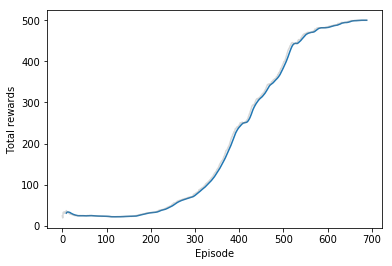

In [51]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

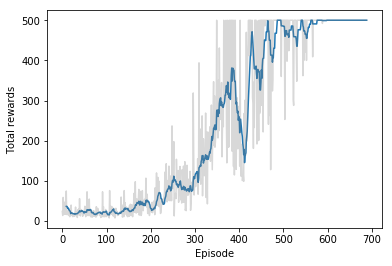

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [53]:
# eps, arr = np.array(dloss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [54]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
